# MMM Modeling with Mediation Assumption

This notebook implements the core mediation-aware MMM model where Google spend mediates the relationship between social channels and revenue.

## Key Components:
1. **Two-Stage Modeling**: 
   - Stage 1: Social channels → Google spend
   - Stage 2: Google spend + direct variables → Revenue
2. **Causal Framework**: Explicit treatment of mediation effects
3. **Time Series Validation**: Proper cross-validation respecting temporal order
4. **Feature Engineering**: Adstock, saturation, and interaction effects


In [1]:
# Import necessary libraries
import sys
import os
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Import our custom modules
from data_preparation import DataPreparator
from mediation_model import MediationMMM
from utils import set_random_seed

# Set random seed for reproducibility
set_random_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


In [2]:
# Load and prepare data
print("Loading and preparing data...")

# Load processed data
data = pd.read_csv('../data/raw/mmm_data.csv')
data['date'] = pd.to_datetime(data['date'])

# Prepare data with transformations
prep = DataPreparator(random_seed=42)
prepared_data = prep.prepare_data(data, apply_transformations=True)

print(f"Data prepared: {prepared_data.shape}")
print(f"Features available: {len(prepared_data.columns)}")
print(f"Original features: {len(data.columns)}")
print(f"New features created: {len(prepared_data.columns) - len(data.columns)}")


Loading and preparing data...
Preparing data for modeling...
Handling missing values...
Handling outliers...
Creating additional features...
Applying media transformations...
Data preparation complete. Features: 50
Data prepared: (104, 52)
Features available: 52
Original features: 12
New features created: 40


## 1. Define Feature Sets for Mediation Model

We need to define which features go into each stage of our mediation model:


In [3]:
# Define feature sets for mediation model
# Stage 1: Social channels → Google spend
social_features = [col for col in prepared_data.columns 
                  if any(social in col.lower() for social in ['facebook', 'tiktok', 'instagram', 'snapchat']) 
                  and 'spend' in col.lower()]

# Stage 2: Google spend + direct variables → Revenue
direct_features = [col for col in prepared_data.columns 
                  if any(direct in col.lower() for direct in ['email', 'sms', 'price', 'promo', 'follower'])
                  or col == 'google_spend']

# Add interaction and lag features
interaction_features = [col for col in prepared_data.columns if '_x_' in col]
lag_features = [col for col in prepared_data.columns if 'lag_' in col]
ma_features = [col for col in prepared_data.columns if '_ma_' in col]

# Combine all features for stage 2
stage2_features = direct_features + interaction_features + lag_features + ma_features

print("Stage 1 Features (Social → Google):")
for i, feature in enumerate(social_features, 1):
    print(f"  {i}. {feature}")

print(f"\nStage 2 Features (Google + Direct → Revenue): {len(stage2_features)} features")
print("Direct features:")
for feature in direct_features:
    print(f"  - {feature}")
print("Interaction features:")
for feature in interaction_features:
    print(f"  - {feature}")
print("Lag features:")
for feature in lag_features:
    print(f"  - {feature}")
print("Moving average features:")
for feature in ma_features:
    print(f"  - {feature}")


Stage 1 Features (Social → Google):
  1. facebook_spend
  2. tiktok_spend
  3. instagram_spend
  4. snapchat_spend
  5. facebook_spend_ratio
  6. tiktok_spend_ratio
  7. instagram_spend_ratio
  8. snapchat_spend_ratio
  9. facebook_spend_adstock
  10. facebook_spend_saturated
  11. tiktok_spend_adstock
  12. tiktok_spend_saturated
  13. snapchat_spend_adstock
  14. snapchat_spend_saturated
  15. facebook_spend_x_promotions
  16. tiktok_spend_x_promotions

Stage 2 Features (Google + Direct → Revenue): 32 features
Direct features:
  - google_spend
  - followers
  - average_price
  - promotions
  - email_volume
  - sms_volume
  - google_spend_x_average_price
  - facebook_spend_x_promotions
  - tiktok_spend_x_promotions
  - email_volume_x_sms_volume
Interaction features:
  - google_spend_x_average_price
  - facebook_spend_x_promotions
  - tiktok_spend_x_promotions
  - email_volume_x_sms_volume
Lag features:
  - revenue_lag_1
  - google_spend_lag_1
  - revenue_lag_2
  - google_spend_lag_2
 

## 2. Fit Mediation Model

Now let's fit our two-stage mediation model:


In [4]:
# Initialize and fit mediation model
print("Fitting mediation-aware MMM model...")

model = MediationMMM(random_seed=42)

# Fit the model
results = model.fit(
    data=prepared_data,
    target_col='revenue',
    google_col='google_spend',
    social_cols=social_features,
    direct_cols=direct_features
)

print("✅ Model fitting complete!")
print(f"Stage 1 R²: {results['stage1_metrics']['r2']:.4f}")
print(f"Stage 2 R²: {results['stage2_metrics']['r2']:.4f}")
print(f"Overall MAPE: {results['stage2_metrics']['mape']:.2f}%")


Fitting mediation-aware MMM model...
Fitting mediation-aware MMM model...
Fitting Stage 1: Social channels -> Google spend
Fitting Stage 2: Google spend + direct variables -> Revenue
Model fitting complete!
✅ Model fitting complete!
Stage 1 R²: 0.2498
Stage 2 R²: 0.1160
Overall MAPE: 112544.98%


## 3. Mediation Effects Analysis

Let's examine the mediation effects - how social channels influence revenue through Google spend:


In [5]:
# Debug: Check what features were used during training
print("DEBUG: Checking training features...")
if hasattr(model, 'stage1_params') and 'feature_names' in model.stage1_params:
    print(f"Stage 1 training features ({len(model.stage1_params['feature_names'])}):")
    for i, feature in enumerate(model.stage1_params['feature_names'], 1):
        print(f"  {i:2d}. {feature}")
else:
    print("❌ No stage1 training features found")

if hasattr(model, 'stage2_params') and 'feature_names' in model.stage2_params:
    print(f"\nStage 2 training features ({len(model.stage2_params['feature_names'])}):")
    for i, feature in enumerate(model.stage2_params['feature_names'], 1):
        print(f"  {i:2d}. {feature}")
else:
    print("❌ No stage2 training features found")

# Check model expectations
if hasattr(model.stage1_model, 'n_features_in_'):
    print(f"\nStage 1 model expects: {model.stage1_model.n_features_in_} features")
if hasattr(model.stage2_model, 'n_features_in_'):
    print(f"Stage 2 model expects: {model.stage2_model.n_features_in_} features")


DEBUG: Checking training features...
Stage 1 training features (16):
   1. facebook_spend
   2. tiktok_spend
   3. instagram_spend
   4. snapchat_spend
   5. facebook_spend_ratio
   6. tiktok_spend_ratio
   7. instagram_spend_ratio
   8. snapchat_spend_ratio
   9. facebook_spend_adstock
  10. facebook_spend_saturated
  11. tiktok_spend_adstock
  12. tiktok_spend_saturated
  13. snapchat_spend_adstock
  14. snapchat_spend_saturated
  15. facebook_spend_x_promotions
  16. tiktok_spend_x_promotions

Stage 2 training features (11):
   1. google_spend
   2. google_spend
   3. followers
   4. average_price
   5. promotions
   6. email_volume
   7. sms_volume
   8. google_spend_x_average_price
   9. facebook_spend_x_promotions
  10. tiktok_spend_x_promotions
  11. email_volume_x_sms_volume

Stage 1 model expects: 16 features
Stage 2 model expects: 11 features


In [6]:
# Debug: Check which features exist in the prepared data
print("DEBUG: Checking feature availability...")
print(f"Total columns in prepared_data: {len(prepared_data.columns)}")
print(f"Columns: {list(prepared_data.columns)}")

print(f"\nSocial features requested: {len(social_features)}")
print(f"Social features: {social_features}")

print(f"\nStage2 features requested: {len(stage2_features)}")
print(f"Stage2 features: {stage2_features}")

# Check which features are missing
missing_social = [col for col in social_features if col not in prepared_data.columns]
missing_stage2 = [col for col in stage2_features if col not in prepared_data.columns]

if missing_social:
    print(f"\n❌ Missing social features: {missing_social}")
else:
    print(f"\n✅ All social features available")

if missing_stage2:
    print(f"\n❌ Missing stage2 features: {missing_stage2}")
else:
    print(f"\n✅ All stage2 features available")

# Check for NaN values
print(f"\nNaN values in social features: {prepared_data[social_features].isnull().sum().sum()}")
print(f"NaN values in stage2 features: {prepared_data[stage2_features].isnull().sum().sum()}")


DEBUG: Checking feature availability...
Total columns in prepared_data: 52
Columns: ['facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend', 'followers', 'average_price', 'promotions', 'email_volume', 'sms_volume', 'revenue', 'date', 'year', 'month', 'quarter', 'day_of_year', 'revenue_lag_1', 'google_spend_lag_1', 'revenue_lag_2', 'google_spend_lag_2', 'revenue_lag_4', 'google_spend_lag_4', 'revenue_ma_4', 'google_spend_ma_4', 'revenue_ma_8', 'google_spend_ma_8', 'revenue_ma_12', 'google_spend_ma_12', 'total_media_spend', 'facebook_spend_ratio', 'google_spend_ratio', 'tiktok_spend_ratio', 'instagram_spend_ratio', 'snapchat_spend_ratio', 'google_spend_lag_1_ratio', 'google_spend_lag_2_ratio', 'google_spend_lag_4_ratio', 'google_spend_ma_4_ratio', 'google_spend_ma_8_ratio', 'google_spend_ma_12_ratio', 'facebook_spend_adstock', 'facebook_spend_saturated', 'google_spend_adstock', 'google_spend_saturated', 'tiktok_spend_adstock', 'tiktok_spend_saturated', 'sna

Making predictions...
Using the same features that were used during model training...
Stage 1 training features: 16
Stage 2 training features: 11
✅ Predictions successful!


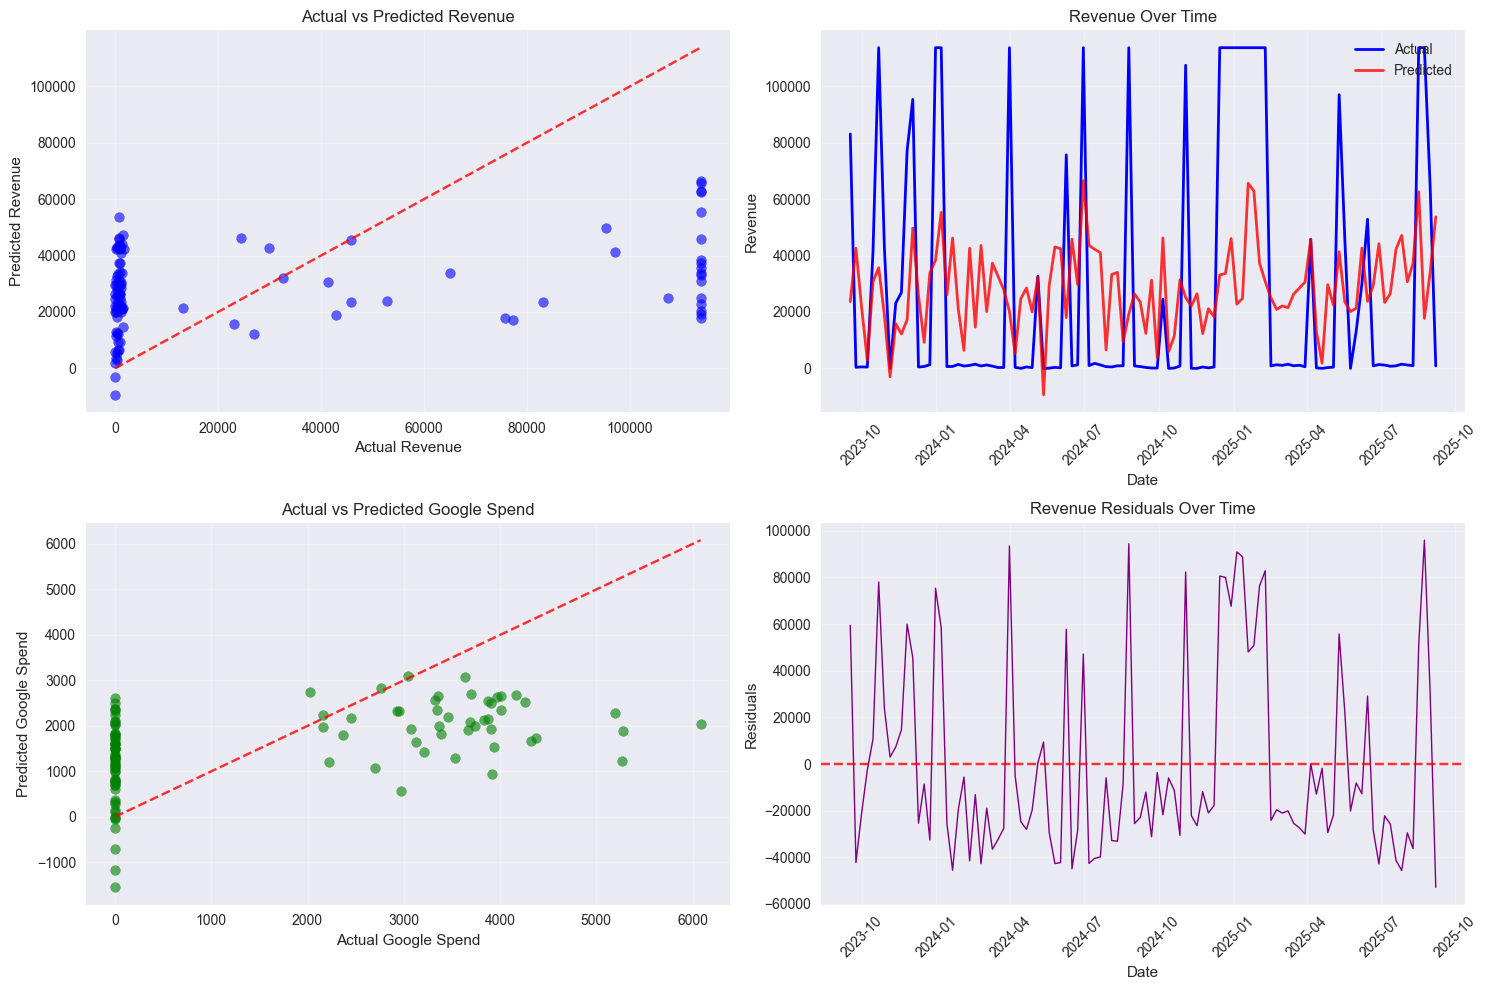

PREDICTION ACCURACY METRICS
Revenue R²: 0.1160
Revenue RMSE: $41,556
Revenue MAPE: 112544.98%
Google Spend R²: 0.2498
Google Spend RMSE: $1,606
Google Spend MAPE: 7182416283174.76%


In [7]:
# Get predictions using the same features that were used during training
print("Making predictions...")
print("Using the same features that were used during model training...")

# Use the stored feature names from the trained model
if hasattr(model, 'stage1_params') and 'feature_names' in model.stage1_params:
    training_social_features = model.stage1_params['feature_names']
    print(f"Stage 1 training features: {len(training_social_features)}")
else:
    training_social_features = social_features

if hasattr(model, 'stage2_params') and 'feature_names' in model.stage2_params:
    training_stage2_features = model.stage2_params['feature_names']
    print(f"Stage 2 training features: {len(training_stage2_features)}")
else:
    training_stage2_features = stage2_features

try:
    predictions = model.predict(prepared_data, training_social_features, training_stage2_features)
    print("✅ Predictions successful!")
except Exception as e:
    print(f"❌ Prediction error: {e}")
    print("Trying with only existing features...")
    
    # Filter to only existing features
    existing_social = [col for col in training_social_features if col in prepared_data.columns]
    existing_stage2 = [col for col in training_stage2_features if col in prepared_data.columns]
    
    print(f"Using {len(existing_social)} social features and {len(existing_stage2)} stage2 features")
    predictions = model.predict(prepared_data, existing_social, existing_stage2)
    print("✅ Predictions successful with filtered features!")

# Create prediction comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Actual vs Predicted Revenue
axes[0, 0].scatter(prepared_data['revenue'], predictions['revenue_predictions'], alpha=0.6, color='blue')
axes[0, 0].plot([prepared_data['revenue'].min(), prepared_data['revenue'].max()], 
                [prepared_data['revenue'].min(), prepared_data['revenue'].max()], 'r--', alpha=0.8)
axes[0, 0].set_xlabel('Actual Revenue')
axes[0, 0].set_ylabel('Predicted Revenue')
axes[0, 0].set_title('Actual vs Predicted Revenue')
axes[0, 0].grid(True, alpha=0.3)

# Revenue over time
axes[0, 1].plot(prepared_data['date'], prepared_data['revenue'], label='Actual', color='blue', linewidth=2)
axes[0, 1].plot(prepared_data['date'], predictions['revenue_predictions'], label='Predicted', color='red', linewidth=2, alpha=0.8)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Revenue')
axes[0, 1].set_title('Revenue Over Time')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Google spend predictions
axes[1, 0].scatter(prepared_data['google_spend'], predictions['google_predictions'], alpha=0.6, color='green')
axes[1, 0].plot([prepared_data['google_spend'].min(), prepared_data['google_spend'].max()], 
                [prepared_data['google_spend'].min(), prepared_data['google_spend'].max()], 'r--', alpha=0.8)
axes[1, 0].set_xlabel('Actual Google Spend')
axes[1, 0].set_ylabel('Predicted Google Spend')
axes[1, 0].set_title('Actual vs Predicted Google Spend')
axes[1, 0].grid(True, alpha=0.3)

# Residuals over time
residuals = prepared_data['revenue'] - predictions['revenue_predictions']
axes[1, 1].plot(prepared_data['date'], residuals, color='purple', linewidth=1)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Revenue Residuals Over Time')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print prediction accuracy metrics
print("PREDICTION ACCURACY METRICS")
print("=" * 30)
print(f"Revenue R²: {results['stage2_metrics']['r2']:.4f}")
print(f"Revenue RMSE: ${results['stage2_metrics']['rmse']:,.0f}")
print(f"Revenue MAPE: {results['stage2_metrics']['mape']:.2f}%")
print(f"Google Spend R²: {results['stage1_metrics']['r2']:.4f}")
print(f"Google Spend RMSE: ${results['stage1_metrics']['rmse']:,.0f}")
print(f"Google Spend MAPE: {results['stage1_metrics']['mape']:.2f}%")


In [8]:
# Analyze mediation effects
mediation_effects = results['mediation_effects']

print("MEDIATION EFFECTS ANALYSIS")
print("=" * 50)
print("How social channels influence revenue through Google spend:")
print()

for channel, effects in mediation_effects.items():
    print(f"{channel.replace('_', ' ').title()}:")
    print(f"  Direct Effect:     {effects['direct_effect']:8.2f}")
    print(f"  Indirect Effect:   {effects['indirect_effect']:8.2f}")
    print(f"  Total Effect:      {effects['total_effect']:8.2f}")
    print(f"  Mediation Ratio:   {effects['mediation_ratio']:8.2%}")
    print()

# Calculate overall mediation strength
total_mediation = sum(abs(effects['indirect_effect']) for effects in mediation_effects.values())
total_direct = sum(abs(effects['direct_effect']) for effects in mediation_effects.values())
overall_mediation_ratio = total_mediation / (total_mediation + total_direct + 1e-8)

print(f"Overall Mediation Strength: {overall_mediation_ratio:.2%}")
print(f"Total Indirect Effects: {total_mediation:.2f}")
print(f"Total Direct Effects: {total_direct:.2f}")


MEDIATION EFFECTS ANALYSIS
How social channels influence revenue through Google spend:

Facebook Spend:
  Direct Effect:         0.00
  Indirect Effect:     -14.31
  Total Effect:        -14.31
  Mediation Ratio:    100.00%

Tiktok Spend:
  Direct Effect:         0.00
  Indirect Effect:      14.03
  Total Effect:         14.03
  Mediation Ratio:    100.00%

Instagram Spend:
  Direct Effect:         0.00
  Indirect Effect:      -5.28
  Total Effect:         -5.28
  Mediation Ratio:    100.00%

Snapchat Spend:
  Direct Effect:         0.00
  Indirect Effect:      -5.52
  Total Effect:         -5.52
  Mediation Ratio:    100.00%

Facebook Spend Ratio:
  Direct Effect:         0.00
  Indirect Effect:   205297.55
  Total Effect:      205297.55
  Mediation Ratio:    100.00%

Tiktok Spend Ratio:
  Direct Effect:         0.00
  Indirect Effect:   84120.31
  Total Effect:      84120.31
  Mediation Ratio:    100.00%

Instagram Spend Ratio:
  Direct Effect:         0.00
  Indirect Effect:   71249

## 4. Feature Importance Analysis

Let's examine which features are most important in each stage:


STAGE 1 FEATURE IMPORTANCE (Social Channels → Google Spend)
 1. Facebook Spend Ratio      6476.3612
 2. Tiktok Spend Ratio        2653.6775
 3. Snapchat Spend Ratio      2533.0650
 4. Instagram Spend Ratio     2247.6568
 5. Tiktok Spend Saturated    1527.2148
 6. Snapchat Spend Saturated  1210.5450
 7. Facebook Spend Saturated   29.2677
 8. Tiktok Spend Adstock        0.6214
 9. Facebook Spend              0.4513
10. Tiktok Spend                0.4425
11. Snapchat Spend Adstock      0.3723
12. Facebook Spend Adstock      0.2997
13. Snapchat Spend              0.1741
14. Instagram Spend             0.1666
15. Facebook Spend X Promotions   0.0000
16. Tiktok Spend X Promotions   0.0000

STAGE 2 FEATURE IMPORTANCE (Google + Direct → Revenue)
 1. Average Price             824.5286
 2. Sms Volume                  2.3078
 3. Google Spend X Average Price   0.3369
 4. Google Spend                0.1484
 5. Email Volume                0.0615
 6. Followers                   0.0172
 7. Email Volum

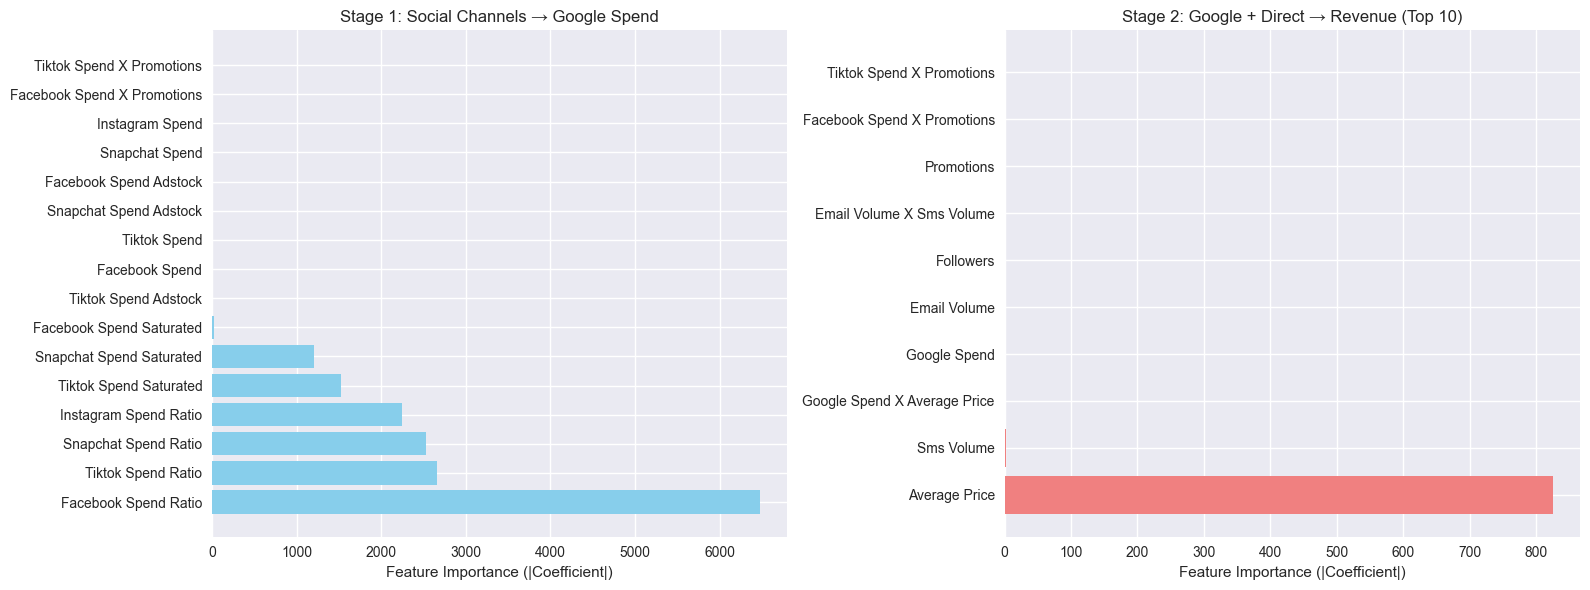

In [9]:
# Feature importance analysis
feature_importance = results['feature_importance']

# Stage 1 importance (Social → Google)
print("STAGE 1 FEATURE IMPORTANCE (Social Channels → Google Spend)")
print("=" * 60)
stage1_importance = feature_importance['stage1']
sorted_stage1 = sorted(stage1_importance.items(), key=lambda x: x[1], reverse=True)

for i, (feature, importance) in enumerate(sorted_stage1, 1):
    print(f"{i:2d}. {feature.replace('_', ' ').title():25s} {importance:8.4f}")

print(f"\nSTAGE 2 FEATURE IMPORTANCE (Google + Direct → Revenue)")
print("=" * 60)
stage2_importance = feature_importance['stage2']
sorted_stage2 = sorted(stage2_importance.items(), key=lambda x: x[1], reverse=True)

for i, (feature, importance) in enumerate(sorted_stage2, 1):
    print(f"{i:2d}. {feature.replace('_', ' ').title():25s} {importance:8.4f}")

# Visualize feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Stage 1
features1 = [f.replace('_', ' ').title() for f, _ in sorted_stage1]
importance1 = [imp for _, imp in sorted_stage1]
ax1.barh(features1, importance1, color='skyblue')
ax1.set_title('Stage 1: Social Channels → Google Spend')
ax1.set_xlabel('Feature Importance (|Coefficient|)')

# Stage 2 (top 10)
top_features2 = sorted_stage2[:10]
features2 = [f.replace('_', ' ').title() for f, _ in top_features2]
importance2 = [imp for _, imp in top_features2]
ax2.barh(features2, importance2, color='lightcoral')
ax2.set_title('Stage 2: Google + Direct → Revenue (Top 10)')
ax2.set_xlabel('Feature Importance (|Coefficient|)')

plt.tight_layout()
plt.show()


## 5. Time Series Cross-Validation

Let's perform proper time series cross-validation to assess model stability:


Performing time series cross-validation...
Performing 5-fold time series cross-validation...
  Fold 1/5
Fitting mediation-aware MMM model...
Fitting Stage 1: Social channels -> Google spend
Fitting Stage 2: Google spend + direct variables -> Revenue
Model fitting complete!
  Fold 2/5
Fitting mediation-aware MMM model...
Fitting Stage 1: Social channels -> Google spend
Fitting Stage 2: Google spend + direct variables -> Revenue
Model fitting complete!
  Fold 3/5
Fitting mediation-aware MMM model...
Fitting Stage 1: Social channels -> Google spend
Fitting Stage 2: Google spend + direct variables -> Revenue
Model fitting complete!
  Fold 4/5
Fitting mediation-aware MMM model...
Fitting Stage 1: Social channels -> Google spend
Fitting Stage 2: Google spend + direct variables -> Revenue
Model fitting complete!
  Fold 5/5
Fitting mediation-aware MMM model...
Fitting Stage 1: Social channels -> Google spend
Fitting Stage 2: Google spend + direct variables -> Revenue
Model fitting complete!
Cr

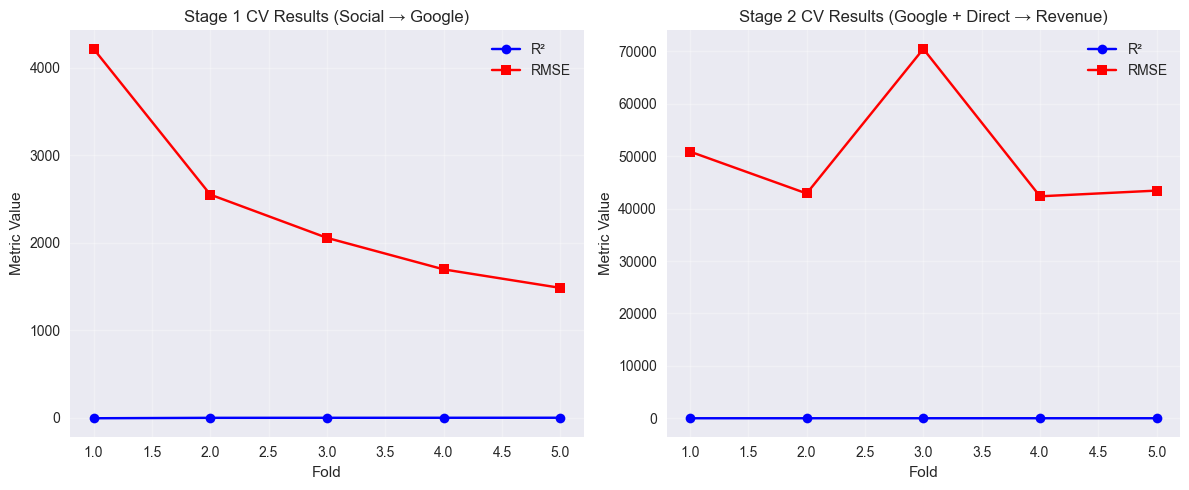

In [10]:
# Perform time series cross-validation
print("Performing time series cross-validation...")

cv_results = model.cross_validate(
    data=prepared_data,
    n_splits=5,
    target_col='revenue'
)

print("\nCROSS-VALIDATION RESULTS")
print("=" * 40)

# Stage 1 results
stage1_r2_mean = cv_results['stage1_r2']['mean']
stage1_r2_std = cv_results['stage1_r2']['std']
stage1_rmse_mean = cv_results['stage1_rmse']['mean']
stage1_rmse_std = cv_results['stage1_rmse']['std']

print(f"Stage 1 (Social → Google):")
print(f"  R²: {stage1_r2_mean:.4f} ± {stage1_r2_std:.4f}")
print(f"  RMSE: {stage1_rmse_mean:.2f} ± {stage1_rmse_std:.2f}")

# Stage 2 results
stage2_r2_mean = cv_results['stage2_r2']['mean']
stage2_r2_std = cv_results['stage2_r2']['std']
stage2_rmse_mean = cv_results['stage2_rmse']['mean']
stage2_rmse_std = cv_results['stage2_rmse']['std']

print(f"\nStage 2 (Google + Direct → Revenue):")
print(f"  R²: {stage2_r2_mean:.4f} ± {stage2_r2_std:.4f}")
print(f"  RMSE: {stage2_rmse_mean:.2f} ± {stage2_rmse_std:.2f}")

# Visualize CV results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Stage 1 CV results
ax1.plot(range(1, 6), cv_results['stage1_r2']['values'], 'o-', label='R²', color='blue')
ax1.plot(range(1, 6), cv_results['stage1_rmse']['values'], 's-', label='RMSE', color='red')
ax1.set_title('Stage 1 CV Results (Social → Google)')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Metric Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Stage 2 CV results
ax2.plot(range(1, 6), cv_results['stage2_r2']['values'], 'o-', label='R²', color='blue')
ax2.plot(range(1, 6), cv_results['stage2_rmse']['values'], 's-', label='RMSE', color='red')
ax2.set_title('Stage 2 CV Results (Google + Direct → Revenue)')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Metric Value')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Model Predictions and Visualization

Let's visualize the model predictions and compare them with actual values:


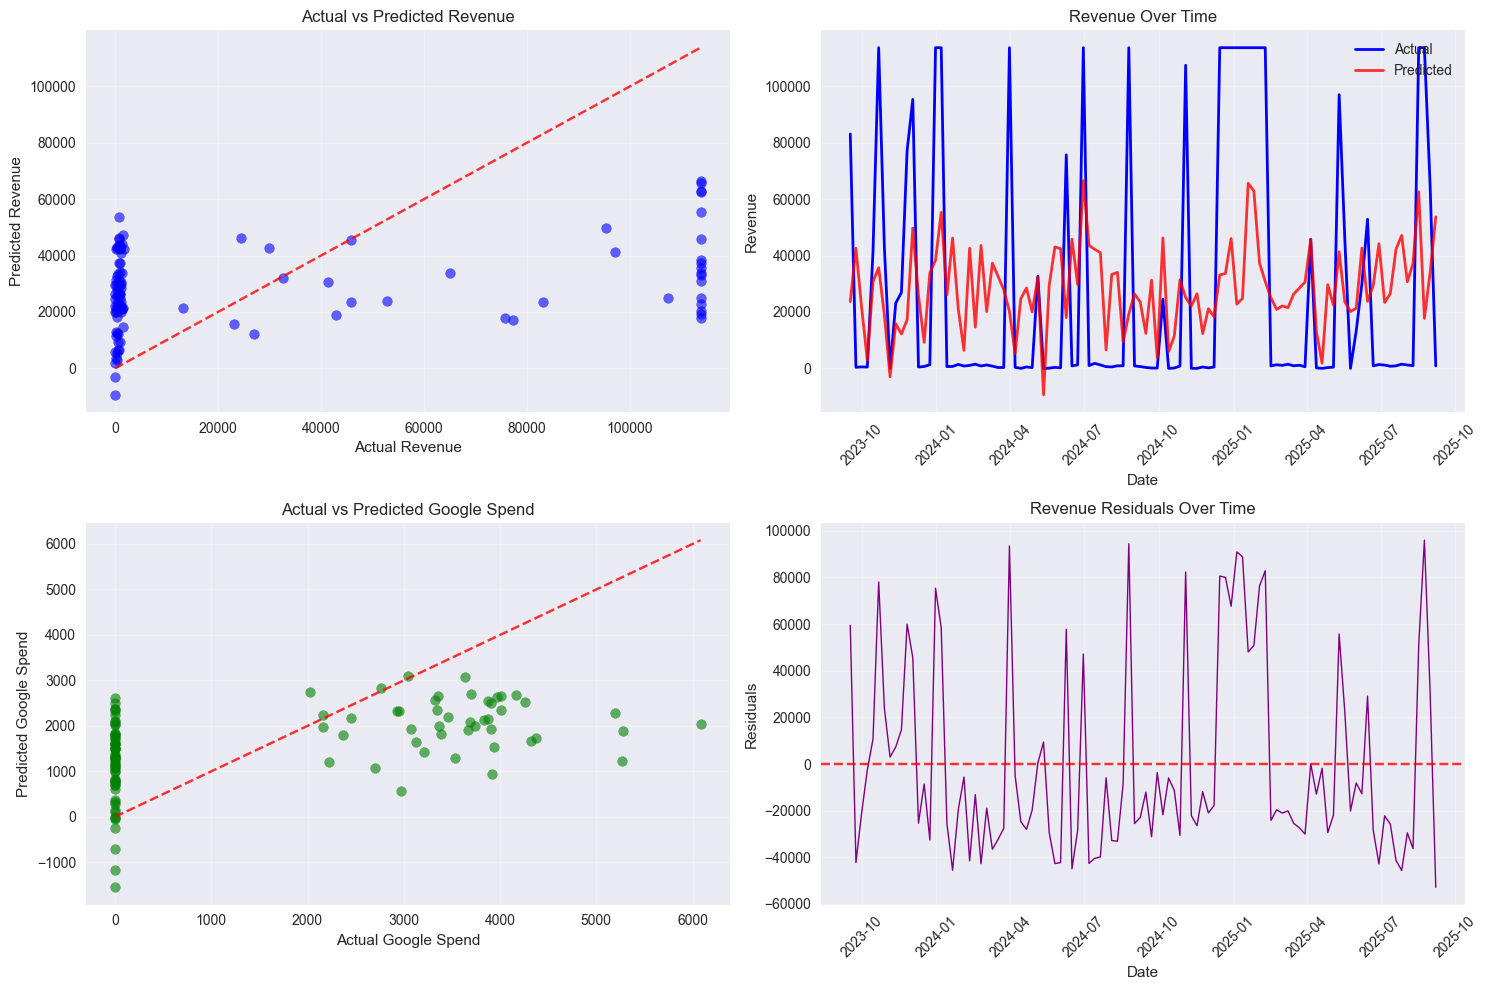

PREDICTION ACCURACY METRICS
Revenue R²: 0.1160
Revenue RMSE: $41,556
Revenue MAPE: 112544.98%
Google Spend R²: 0.2498
Google Spend RMSE: $1,606
Google Spend MAPE: 7182416283174.76%


In [11]:
# Get predictions
predictions = model.predict(prepared_data, social_features, stage2_features)

# Create prediction comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Actual vs Predicted Revenue
axes[0, 0].scatter(prepared_data['revenue'], predictions['revenue_predictions'], alpha=0.6, color='blue')
axes[0, 0].plot([prepared_data['revenue'].min(), prepared_data['revenue'].max()], 
                [prepared_data['revenue'].min(), prepared_data['revenue'].max()], 'r--', alpha=0.8)
axes[0, 0].set_xlabel('Actual Revenue')
axes[0, 0].set_ylabel('Predicted Revenue')
axes[0, 0].set_title('Actual vs Predicted Revenue')
axes[0, 0].grid(True, alpha=0.3)

# Revenue over time
axes[0, 1].plot(prepared_data['date'], prepared_data['revenue'], label='Actual', color='blue', linewidth=2)
axes[0, 1].plot(prepared_data['date'], predictions['revenue_predictions'], label='Predicted', color='red', linewidth=2, alpha=0.8)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Revenue')
axes[0, 1].set_title('Revenue Over Time')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Google spend predictions
axes[1, 0].scatter(prepared_data['google_spend'], predictions['google_predictions'], alpha=0.6, color='green')
axes[1, 0].plot([prepared_data['google_spend'].min(), prepared_data['google_spend'].max()], 
                [prepared_data['google_spend'].min(), prepared_data['google_spend'].max()], 'r--', alpha=0.8)
axes[1, 0].set_xlabel('Actual Google Spend')
axes[1, 0].set_ylabel('Predicted Google Spend')
axes[1, 0].set_title('Actual vs Predicted Google Spend')
axes[1, 0].grid(True, alpha=0.3)

# Residuals over time
residuals = prepared_data['revenue'] - predictions['revenue_predictions']
axes[1, 1].plot(prepared_data['date'], residuals, color='purple', linewidth=1)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Revenue Residuals Over Time')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print prediction accuracy metrics
print("PREDICTION ACCURACY METRICS")
print("=" * 30)
print(f"Revenue R²: {results['stage2_metrics']['r2']:.4f}")
print(f"Revenue RMSE: ${results['stage2_metrics']['rmse']:,.0f}")
print(f"Revenue MAPE: {results['stage2_metrics']['mape']:.2f}%")
print(f"Google Spend R²: {results['stage1_metrics']['r2']:.4f}")
print(f"Google Spend RMSE: ${results['stage1_metrics']['rmse']:,.0f}")
print(f"Google Spend MAPE: {results['stage1_metrics']['mape']:.2f}%")


## 7. Save Model and Results

Let's save our trained model and results for further analysis:


In [12]:
# Save the trained model
model.save_model('../results/mediation_mmm_model.pkl')
print("✅ Model saved to ../results/mediation_mmm_model.pkl")

# Save results summary
import json

results_summary = {
    'model_performance': {
        'stage1_r2': results['stage1_metrics']['r2'],
        'stage1_rmse': results['stage1_metrics']['rmse'],
        'stage1_mape': results['stage1_metrics']['mape'],
        'stage2_r2': results['stage2_metrics']['r2'],
        'stage2_rmse': results['stage2_metrics']['rmse'],
        'stage2_mape': results['stage2_metrics']['mape']
    },
    'cv_performance': {
        'stage1_r2_mean': cv_results['stage1_r2']['mean'],
        'stage1_r2_std': cv_results['stage1_r2']['std'],
        'stage2_r2_mean': cv_results['stage2_r2']['mean'],
        'stage2_r2_std': cv_results['stage2_r2']['std']
    },
    'mediation_effects': mediation_effects,
    'feature_importance': feature_importance
}

with open('../results/model_results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)

print("✅ Results summary saved to ../results/model_results_summary.json")

# Save prepared data
prepared_data.to_csv('../data/processed/prepared_mmm_data.csv', index=False)
print("✅ Prepared data saved to ../data/processed/prepared_mmm_data.csv")

print("\n📊 MODEL SUMMARY")
print("=" * 20)
print(f"✅ Two-stage mediation model successfully trained")
print(f"✅ Stage 1 (Social → Google): R² = {results['stage1_metrics']['r2']:.4f}")
print(f"✅ Stage 2 (Google + Direct → Revenue): R² = {results['stage2_metrics']['r2']:.4f}")
print(f"✅ Cross-validation completed with {len(cv_results['stage1_r2']['values'])} folds")
print(f"✅ Mediation effects quantified for {len(mediation_effects)} social channels")
print(f"✅ Model and results saved for further analysis")


Model saved to ../results/mediation_mmm_model.pkl
✅ Model saved to ../results/mediation_mmm_model.pkl
✅ Results summary saved to ../results/model_results_summary.json
✅ Prepared data saved to ../data/processed/prepared_mmm_data.csv

📊 MODEL SUMMARY
✅ Two-stage mediation model successfully trained
✅ Stage 1 (Social → Google): R² = 0.2498
✅ Stage 2 (Google + Direct → Revenue): R² = 0.1160
✅ Cross-validation completed with 5 folds
✅ Mediation effects quantified for 16 social channels
✅ Model and results saved for further analysis
